In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Finishing up uncertainties

## Fixing the large uncertainty problem

I was having a problem with fit uncertainties, for some hits that looked certain. This was resolved by removing the code that zeroed out high values, and adding code to pad the fitting area with zeroes, so we could still resolve hits near the edge of the area.

In [20]:
def gaussian_2d(xy, a, mu_x, sigma_x, mu_y, sigma_y):
    x, y = xy
    return np.ravel(
        a
        * np.exp(-((x - mu_x) ** 2 / (2 * sigma_x**2)))
        * np.exp(-((y - mu_y) ** 2 / (2 * sigma_y**2)))
    )

def fit_hit(
    data: np.ndarray, centre_loc: tuple[int, int], size: int
) -> tuple[tuple[float, float], tuple[float, float]]:
    """Fits a 2D gaussian to a hit, given the 3x3 around the hit, and the location in
    the main image of the centre pixel of this 3x3

    centre_loc is in format (row, col)

    returns the centre of the Gaussian (in format (row, col)), and its uncertainty"""
    extra_pad = 3
    x, y = np.meshgrid(np.arange(size + 2 * extra_pad), np.arange(size + 2 * extra_pad))

    # get the min value to zero for fit
    data += np.abs(data.min())

    # set all values above half the centre to zero
    #data = np.where(data > data[size // 2, size // 2], 0, data)

    # add some extra padding of zeroes around the data, to prevent fit artefacts
    data = np.pad(data, extra_pad, mode="constant", constant_values=0)

    p0 = [data.max(), size // 2+extra_pad, 1, size // 2+extra_pad, 1]  # assume hit is roughly at centre

    try:
        popt, pcov = curve_fit(gaussian_2d, (x, y), data.ravel(), p0=p0)
    except RuntimeError:
        return (centre_loc, (-1, -1))

    u = np.sqrt(np.diag(pcov))

    if popt[1] > 2048 or popt[3] > 2048:
        print(data, centre_loc, popt, u)

    return (
        centre_loc[0] - size // 2 + popt[3] - extra_pad,
        centre_loc[1] - size // 2 + popt[1] - extra_pad,
    ), (
        u[3],
        u[1],
    )

In [21]:
test_data = np.array([
    [0, 0, 1],
    [0, 0, 0],
    [0, 0, 0]
])

fit_hit(test_data, (1, 1), 3)

((-0.041083531137727114, 2.0410827078175977),
 (0.11688299292265499, 0.11687292030671226))

## Looking at all the uncertainties again

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from spc import SPC
from bragg import EnergyMap
from histograms import make_histogram


img = np.load("data/images/image8.npy")
spc = SPC(img, 75, 30, 2, padding=2, fit_area_size=5)

In [33]:
sorted(spc.all_hit_uncertainties[:, 0])[-10:], sorted(spc.all_hit_uncertainties[:, 1])[-10:]

([0.28430304823777414,
  0.29804425602644646,
  0.3050722183477699,
  0.30514434593470613,
  0.37858487834954424,
  0.440424549319093,
  0.48681612749621234,
  0.7916797576170711,
  3.0945078357176157,
  4.386658633291848],
 [0.30777618945528096,
  0.3235099134881916,
  0.34113053240385144,
  0.3740396914456701,
  0.38436815682882186,
  0.4152400003642418,
  0.5470124045812551,
  0.6862286061729207,
  0.7019489431783793,
  1.0893368235835836])

In [6]:
em = EnergyMap(spc.img, 200, 200, 20, 2, 100, (25, 25), [1218.5, 1188.0])

Good; there are only a few hits with larger uncertainties, and even then, they're not that large.

We now need to convert location uncertainties into energy uncertainties

### Getting energy uncertainties

In [39]:
import sympy

E_vals, self.k, self.D2, self.Ys, y, self.yc, x, self.xc = sympy.symbols("E k D2 Ys y yc x xc")

E_vals = self.k * sympy.sqrt(1 + (self.D2 + self.Ys * (y - self.yc) ** 2) / ((x - self.xc) ** 2))

sympy.diff(E_vals, y), sympy.diff(E_vals, x)

(Ys*k*(2*y - 2*yc)/(2*(x - xc)**2*sqrt((D2 + Ys*(y - yc)**2)/(x - xc)**2 + 1)),
 -k*(D2 + Ys*(y - yc)**2)/((x - xc)**3*sqrt((D2 + Ys*(y - yc)**2)/(x - xc)**2 + 1)))

In [43]:
def sigma_E_vals(k, D2, Ys, yc, xc, x, y, sigma_x, sigma_y):
    dEdx2 = (Ys*k*(2*y - 2*yc)/(2*(x - xc)**2*np.sqrt((D2 + Ys*(y - yc)**2)/(x - xc)**2 + 1)))**2
    dEdy2 = ( -k*(D2 + Ys*(y - yc)**2)/((x - xc)**3*np.sqrt((D2 + Ys*(y - yc)**2)/(x - xc)**2 + 1)))**2

    return np.sqrt(dEdx2 * sigma_x**2 + dEdy2 * sigma_y**2)

# test on a random hit
i = 250
loc = spc.all_hit_locations[i]
unc = spc.all_hit_uncertainties[i]

energy = em.calculate_energy(loc)
self.xc, self.yc, self.D2, self.Ys = em.hyp_params

sigma_E_vals(em.k, self.D2, self.Ys, self.yc, self.xc, loc[1], loc[0], unc[1], unc[0]), energy


(0.030162802184507103, 1438.2687643067836)

This seems a bit low. Let's look at the hit uncertainties

In [44]:
np.median(spc.all_hit_uncertainties, axis=0)

array([0.08733666, 0.08714552])

So, the median hit uncertainty is less than a pixel. This seems a little unrealistic - we probably don't know the location to within a 10th of a pixel. We could use the charge spread as a better estimate. I've modified fit_hit to return the gaussian SD as the uncertainty - let's see what we get

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from spc import SPC
from bragg import EnergyMap
from histograms import make_histogram

img = np.load("data/images/image8.npy")
spc = SPC(img, 75, 30, 2, padding=2, fit_area_size=5)

In [4]:
np.median(spc.all_hit_uncertainties, axis=0)

array([1.27163702, 1.27146877])

This is significantly larger - more than a pixel. Let's see what energy uncertainty this gives

In [7]:
def sigma_E_vals(k, D2, Ys, yc, xc, x, y, sigma_x, sigma_y):
    dEdx2 = (Ys*k*(2*y - 2*yc)/(2*(x - xc)**2*np.sqrt((D2 + Ys*(y - yc)**2)/(x - xc)**2 + 1)))**2
    dEdy2 = ( -k*(D2 + Ys*(y - yc)**2)/((x - xc)**3*np.sqrt((D2 + Ys*(y - yc)**2)/(x - xc)**2 + 1)))**2

    return np.sqrt(dEdx2 * sigma_x**2 + dEdy2 * sigma_y**2)

# test on a random hit
i = 250
loc = spc.all_hit_locations[i]
unc = spc.all_hit_uncertainties[i]

energy = em.calculate_energy(loc)
self.xc, self.yc, self.D2, self.Ys = em.hyp_params

sigma_E_vals(em.k, self.D2, self.Ys, self.yc, self.xc, loc[1], loc[0], unc[1], unc[0]), energy


(0.2246621774374969, 1438.2687643067836)

About 0.2eV - seems much more reasonable. Let's stick with this then.

## Spectrum with uncertainties

We now need to create a spectrum with uncertainties. Let's make a new class, representing a spectrum

In [48]:
from spc import SPC
from bragg import EnergyMap
from scipy.special import erf
from histograms import make_histogram


class Spectrum(object):

    def __init__(
        self, spc: SPC, em: EnergyMap, bin_width: float, Emin: float, Emax: float
    ):
        self.spc = spc
        self.em = em
        self.bin_width = bin_width
        self.Emin = Emin
        self.Emax = Emax

        self.hit_locs = spc.all_hit_locations
        self.hit_loc_uncs = spc.all_hit_uncertainties
        self.energies = np.array([em.calculate_energy(loc) for loc in self.hit_locs])

        self.k = em.k
        self.D2, self.Ys, self.yc, self.xc = em.hyp_params

        self.energy_uncs = self.sigma_E(*self.hit_locs.T, *self.hit_loc_uncs.T)

        self.make_spectrum()

    def sigma_E(self, x: float, y: float, sigma_x: float, sigma_y: float) -> float:
        """Calculate the energy uncertainty for a given hit"""
        dEdx2 = (
            self.Ys
            * self.k
            * (2 * y - 2 * self.yc)
            / (
                2
                * (x - self.xc) ** 2
                * np.sqrt(
                    (self.D2 + self.Ys * (y - self.yc) ** 2) / (x - self.xc) ** 2 + 1
                )
            )
        ) ** 2
        dEdy2 = (
            -self.k
            * (self.D2 + self.Ys * (y - self.yc) ** 2)
            / (
                (x - self.xc) ** 3
                * np.sqrt(
                    (self.D2 + self.Ys * (y - self.yc) ** 2) / (x - self.xc) ** 2 + 1
                )
            )
        ) ** 2

        return np.sqrt(dEdx2 * sigma_x**2 + dEdy2 * sigma_y**2)

    def pij(self, Ei, sigma_Ei, a_j, b_j):
        """Calculate the probability of a hit i being in bin j, given the energy Ei
        and its uncertainty sigma_Ei"""

        u_a = (a_j - Ei) / np.sqrt(2) / sigma_Ei
        u_b = (b_j - Ei) / np.sqrt(2) / sigma_Ei

        return 0.5 * (erf(u_b) - erf(u_a))

    def bin_count_unc(self, a_j, b_j, E_vals, sigma_E_vals):
        """Calculate the standard error of the number of hits in a bin"""
        pij = self.pij(E_vals, sigma_E_vals, a_j, b_j)
        return np.sqrt(np.sum(pij * (1 - pij)))

    def make_spectrum(self):
        """Make the histogram of the energies"""
        bins = np.arange(self.Emin, self.Emax, self.bin_width)
        self.counts, _ = np.histogram(self.energies, bins=bins)

        self.bin_centers = (bins[:-1] + bins[1:]) / 2
        self.count_uncs = np.array(
            [self.bin_count_unc(a, b, self.energies, self.energy_uncs) for a, b in zip(bins[:-1], bins[1:])]
        )

In [93]:
spectrum = Spectrum(spc, em, 2, 1100, 1500)


In [94]:
np.median((spectrum.count_uncs/spectrum.counts))

0.004422950676323843

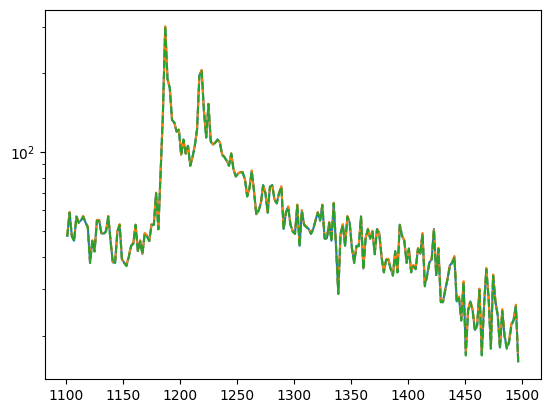

In [96]:
plt.plot(spectrum.bin_centers, spectrum.counts)
plt.plot(spectrum.bin_centers, spectrum.counts + spectrum.count_uncs, linestyle="--")
plt.plot(spectrum.bin_centers, spectrum.counts - spectrum.count_uncs, linestyle="--")
plt.yscale("log")

(1300.0, 1310.0)

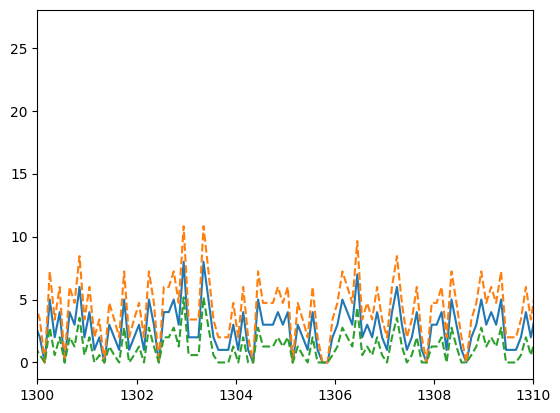

In [70]:
plt.plot(spectrum.bin_centers, spectrum.counts)
plt.plot(spectrum.bin_centers, spectrum.counts + np.sqrt(spectrum.counts), linestyle="--")
plt.plot(spectrum.bin_centers, spectrum.counts - np.sqrt(spectrum.counts), linestyle="--")
plt.xlim(1300,1310)

# Optimising the parameters for the spectrum

So far, we have just randomly picked our parameters. We should optimise these, to minimise the uncertainty in the final spectrum.

Our "hyperparameters" are:
- bin width
- primary threshold
- secondary threshold
- n_sigma

- Bragg map parameters
    - lineout dy
    - lineout xavg period
    - sobel size

For now, I'll leave out the Bragg parameters. We now need to define a loss function that we aim to minimise. A good option might be average relative uncertainty in bin heights, but this will lead to the algorithm making the bin widths as large as possible.

Instead, we could keep bin width constant, and optimise the other parameters, and repeat this for a range of bin widths.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from spc import SPC
from bragg import EnergyMap, Spectrum

img = np.load("data/images/image8.npy")
spc = SPC(img, 75, 30, 2, padding=1, fit_area_size=3)

em = EnergyMap(spc.img, 200, 200, 20, 2, 100, (25, 25), [1218.5, 1188.0])

In [2]:

def loss(primary_threshold, secondary_threshold, n_sigma):
    print(primary_threshold, secondary_threshold, n_sigma)
    spc = SPC(img, primary_threshold, secondary_threshold, n_sigma, fit_hits=False)
    spectrum = Spectrum(spc, em, 2, 1100, 1600, uncertainty_method="poisson")

    return np.nanmean(spectrum.count_uncs/spectrum.counts)

primaries = np.linspace(30, 100, 7)
secondaries = np.linspace(10, 60, 7)

losses = []

for primary in primaries:
    for secondary in secondaries:
        if primary > secondary:
            losses.append([primary, secondary, loss(primary, secondary, 2)])

30.0 10.0 2
30.0 18.333333333333336 2
30.0 26.666666666666668 2
41.666666666666664 10.0 2
41.666666666666664 18.333333333333336 2
41.666666666666664 26.666666666666668 2
41.666666666666664 35.0 2
53.33333333333333 10.0 2
53.33333333333333 18.333333333333336 2
53.33333333333333 26.666666666666668 2
53.33333333333333 35.0 2
53.33333333333333 43.333333333333336 2
53.33333333333333 51.66666666666667 2
65.0 10.0 2
65.0 18.333333333333336 2
65.0 26.666666666666668 2
65.0 35.0 2
65.0 43.333333333333336 2
65.0 51.66666666666667 2
65.0 60.0 2
76.66666666666666 10.0 2
76.66666666666666 18.333333333333336 2
76.66666666666666 26.666666666666668 2
76.66666666666666 35.0 2
76.66666666666666 43.333333333333336 2
76.66666666666666 51.66666666666667 2
76.66666666666666 60.0 2
88.33333333333333 10.0 2
88.33333333333333 18.333333333333336 2
88.33333333333333 26.666666666666668 2
88.33333333333333 35.0 2
88.33333333333333 43.333333333333336 2
88.33333333333333 51.66666666666667 2
88.33333333333333 60.0 2


Text(0, 0.5, 'Secondary threshold')

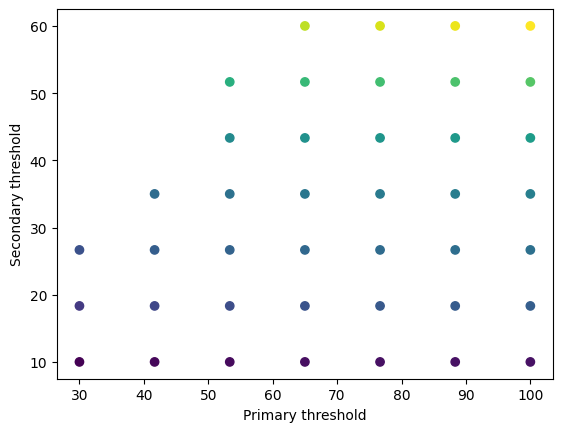

In [7]:
x = np.array(losses)[:, 0]
y = np.array(losses)[:, 1]
z = np.array(losses)[:, 2]
plt.scatter(x, y, c=z, cmap="viridis")
plt.xlabel("Primary threshold")
plt.ylabel("Secondary threshold")

In [9]:
spc1 = SPC(img, 30, 10, 2, fit_hits=False)
spectrum1 = Spectrum(spc1, em, 2, 1100, 1600, uncertainty_method="poisson")

spc2 = SPC(img, 75, 30, 2, fit_hits=False)
spectrum2 = Spectrum(spc2, em, 2, 1100, 1600, uncertainty_method="poisson")

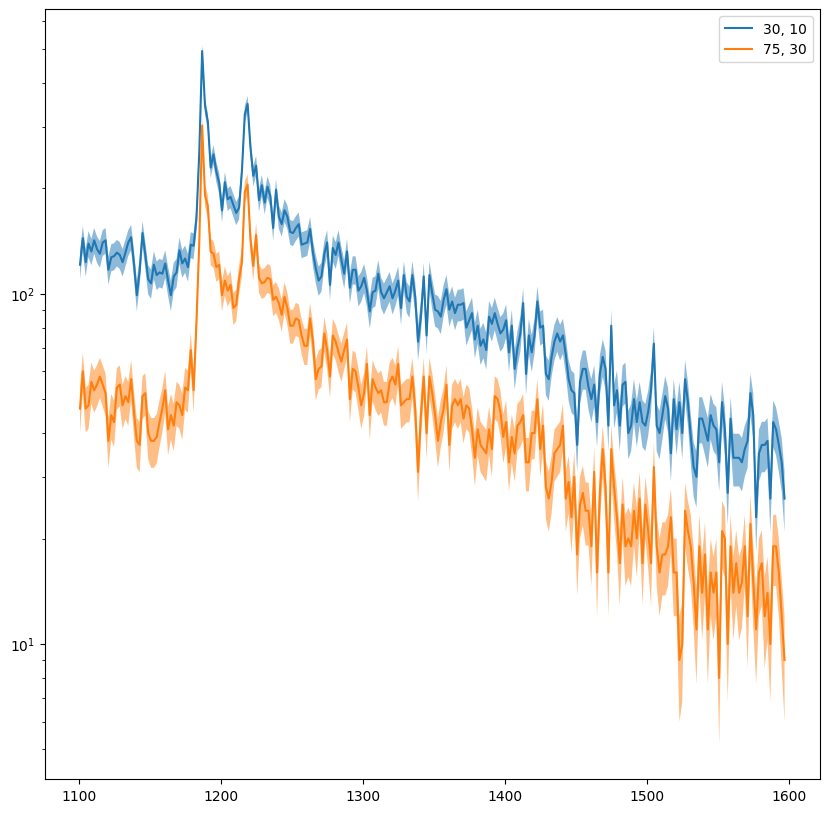

In [18]:
%matplotlib inline
plt.figure(figsize = (10,10))
plt.plot(spectrum1.bin_centers, spectrum1.counts, label="30, 10")
plt.fill_between(spectrum1.bin_centers, spectrum1.counts - spectrum1.count_uncs, spectrum1.counts + spectrum1.count_uncs, alpha=0.5)
plt.plot(spectrum2.bin_centers, spectrum2.counts, label="75, 30")
plt.fill_between(spectrum2.bin_centers, spectrum2.counts - spectrum2.count_uncs, spectrum2.counts + spectrum2.count_uncs, alpha=0.5)

plt.legend()

plt.yscale("log")

In [13]:
def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((y-.5, x-.5), 1,1, fill=False, linewidth=2, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

%matplotlib qt
plt.imshow(spc.img, cmap="jet")

for loc in spc1.all_hit_locations:
    highlight_cell(*loc)

plt.show()

Let's try calculating the uncertainties using the other method  

In [20]:

def loss(primary_threshold, secondary_threshold, n_sigma):
    print(primary_threshold, secondary_threshold, n_sigma)
    spc = SPC(img, primary_threshold, secondary_threshold, n_sigma, fit_hits=True)
    spectrum = Spectrum(spc, em, 2, 1100, 1600, uncertainty_method="full")

    return np.nanmean(spectrum.count_uncs/spectrum.counts)

primaries = np.linspace(30, 100, 7)
secondaries = np.linspace(10, 60, 7)

losses = []

for primary in primaries:
    for secondary in secondaries:
        if primary > secondary:
            losses.append([primary, secondary, loss(primary, secondary, 2)])

30.0 10.0 2
30.0 18.333333333333336 2
30.0 26.666666666666668 2
41.666666666666664 10.0 2
41.666666666666664 18.333333333333336 2
41.666666666666664 26.666666666666668 2
41.666666666666664 35.0 2
53.33333333333333 10.0 2
53.33333333333333 18.333333333333336 2
53.33333333333333 26.666666666666668 2
53.33333333333333 35.0 2
53.33333333333333 43.333333333333336 2
53.33333333333333 51.66666666666667 2
65.0 10.0 2
65.0 18.333333333333336 2
65.0 26.666666666666668 2
65.0 35.0 2
65.0 43.333333333333336 2
65.0 51.66666666666667 2
65.0 60.0 2
76.66666666666666 10.0 2
76.66666666666666 18.333333333333336 2
76.66666666666666 26.666666666666668 2
76.66666666666666 35.0 2
76.66666666666666 43.333333333333336 2
76.66666666666666 51.66666666666667 2
76.66666666666666 60.0 2
88.33333333333333 10.0 2
88.33333333333333 18.333333333333336 2
88.33333333333333 26.666666666666668 2
88.33333333333333 35.0 2
88.33333333333333 43.333333333333336 2
88.33333333333333 51.66666666666667 2
88.33333333333333 60.0 2


array([0.00538137, 0.00696427, 0.00767091, 0.00550997, 0.00732921,
       0.00807549, 0.00858449, 0.00556764, 0.0075109 , 0.008207  ,
       0.00873247, 0.00961209, 0.01104732, 0.00563694, 0.00772241,
       0.00837018, 0.00894935, 0.00989236, 0.01141623, 0.01405274,
       0.00566525, 0.00784494, 0.0084522 , 0.0090441 , 0.00998939,
       0.01158172, 0.01467691, 0.00568441, 0.00793056, 0.00852491,
       0.00914068, 0.01012071, 0.01172002, 0.01488638, 0.00569159,
       0.00795517, 0.008565  , 0.00917284, 0.0101602 , 0.01179597,
       0.01502801])

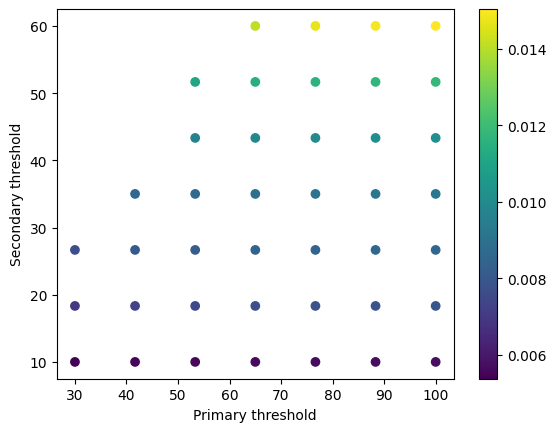

In [23]:
x = np.array(losses)[:, 0]
y = np.array(losses)[:, 1]
z = np.array(losses)[:, 2]
plt.scatter(x, y, c=z, cmap="viridis")
plt.colorbar()
plt.xlabel("Primary threshold")
plt.ylabel("Secondary threshold")
z

In [24]:
spc1 = SPC(img, 30, 10, 2, fit_hits=True)
spectrum1 = Spectrum(spc1, em, 2, 1100, 1600, uncertainty_method="full")

In [30]:
spc2 = SPC(img, 75, 30, 2, fit_hits=True)
spectrum2 = Spectrum(spc2, em, 2, 1100, 1600, uncertainty_method="full")

In [31]:
sorted(spc1.all_hit_uncertainties[:, 0], reverse=True)[:25]

len(spc1.all_hit_uncertainties), len(spc2.all_hit_uncertainties)

(29059, 13809)

In [37]:
print(sorted((spectrum2.count_uncs/spectrum2.counts), reverse=True)[:int(len(spectrum2.counts)/20)])
print(sorted((spectrum1.count_uncs/spectrum1.counts), reverse=True)[:int(len(spectrum1.counts)/20)])


[0.03941563972626606, 0.03448867950103634, 0.030656578914979346, 0.027590964855096205, 0.027590928834367468, 0.0275909241820482, 0.02759091292749271, 0.025082689569776183, 0.025082684780730655, 0.02299247173879329, 0.022992444486707966, 0.022992428807915525]
[0.01656039325919065, 0.01589798501615026, 0.01589797355846198, 0.015286509074009327, 0.013248327128316622, 0.012820957374568958, 0.01282095330142149, 0.012043934244670762, 0.012043926944732582, 0.012043920579350127, 0.011689692167685695, 0.011355724718814242]


The spetrum with very low thresholds still has a smaller uncertainty. Let's try and include the uncertainty in the mean of the gaussian fit with the standard deviation, to get a better representation of the uncertainty.

We can add the sd and unc in mean in quadrature:

In [ ]:
def fit_hit(
    data: np.ndarray, centre_loc: tuple[int, int], size: int, fit_hit
) -> tuple[tuple[float, float], tuple[float, float]]:
    """Fits a 2D gaussian to a hit, given the 3x3 around the hit, and the location in
    the main image of the centre pixel of this 3x3

    centre_loc is in format (row, col)

    returns the centre of the Gaussian (in format (row, col)), and its uncertainty

    if fit_hit is False, returns the centre_loc and (-1, -1)"""

    if not fit_hit:
        return centre_loc, (0, 0)
    extra_pad = 3
    x, y = np.meshgrid(np.arange(size + 2 * extra_pad), np.arange(size + 2 * extra_pad))

    # get the min value to zero for fit
    data += np.abs(data.min())

    # set all values above half the centre to zero
    # data = np.where(data > data[size // 2, size // 2], 0, data)

    # add some extra padding of zeroes around the data, to prevent fit artefacts
    data = np.pad(data, extra_pad, mode="constant", constant_values=0)

    p0 = [
        data.max(),
        size // 2 + extra_pad,
        1,
        size // 2 + extra_pad,
        1,
    ]  # assume hit is roughly at centre

    try:
        popt, pcov = curve_fit(gaussian_2d, (x, y), data.ravel(), p0=p0)
    except RuntimeError:
        return (centre_loc, (-1, -1))

    u = np.sqrt(np.diag(pcov))

    if popt[1] > 2048 or popt[3] > 2048:
        print(data, centre_loc, popt, u)

    uncertainties = (np.sqrt(u[3]**2 + popt[4]**2), np.sqrt(u[1]**2 + popt[2]**2))

    return (
        centre_loc[0] - size // 2 + popt[3] - extra_pad,
        centre_loc[1] - size // 2 + popt[1] - extra_pad,
    ), uncertainties


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from spc import SPC
from bragg import EnergyMap, Spectrum

img = np.load("data/images/image8.npy")
spc = SPC(img, 75, 30, 2, padding=1, fit_area_size=3)

em = EnergyMap(spc.img, 200, 200, 20, 2, 100, (25, 25), [1218.5, 1188.0])

In [7]:
spcs = []
spectra = []

primaries = np.linspace(30, 100, 7)
secondaries = np.linspace(10, 60, 7)

for primary_threshold in primaries:
    for secondary_threshold in secondaries:
        n_sigma=2
        if primary > secondary:
            spc = SPC(img, primary_threshold, secondary_threshold, n_sigma, fit_hits=True)
            spcs.append([primary_threshold, secondary_threshold, spc])
            spectrum = Spectrum(spc, em, 2, 1100, 1600, uncertainty_method="full")
            spectra.append([primary_threshold, secondary_threshold, spectrum])

array([0.005363  , 0.0069441 , 0.00764904, 0.00549125, 0.00730846,
       0.0080534 , 0.00855963, 0.00554824, 0.00748975, 0.00818463,
       0.00870731, 0.00958106, 0.0110084 , 0.00561746, 0.00770188,
       0.00834938, 0.00892594, 0.0098634 , 0.01138019, 0.01400037,
       0.00564598, 0.00782483, 0.00843089, 0.00902006, 0.00995957,
       0.01154425, 0.01462043, 0.00566487, 0.00791009, 0.0085033 ,
       0.00911626, 0.01009026, 0.01168171, 0.01482808, 0.00567274,
       0.00793468, 0.00854342, 0.00914846, 0.01012974, 0.01175748,
       0.01496888])

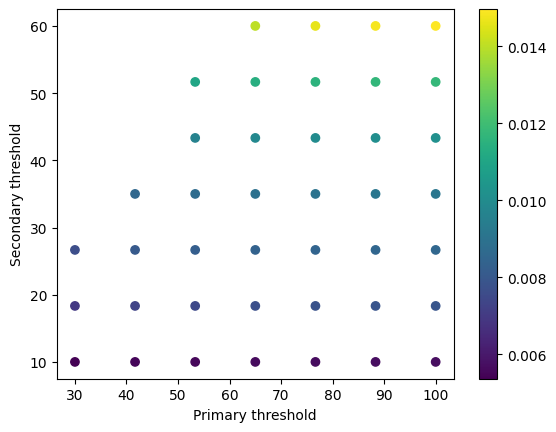

In [5]:
x = np.array(losses)[:, 0]
y = np.array(losses)[:, 1]
z = np.array(losses)[:, 2]
plt.scatter(x, y, c=z, cmap="viridis")
plt.colorbar()
plt.xlabel("Primary threshold")
plt.ylabel("Secondary threshold")
z

Text(0.5, 1.0, 'Loss using absolute uncertainties and full uncertainty method')

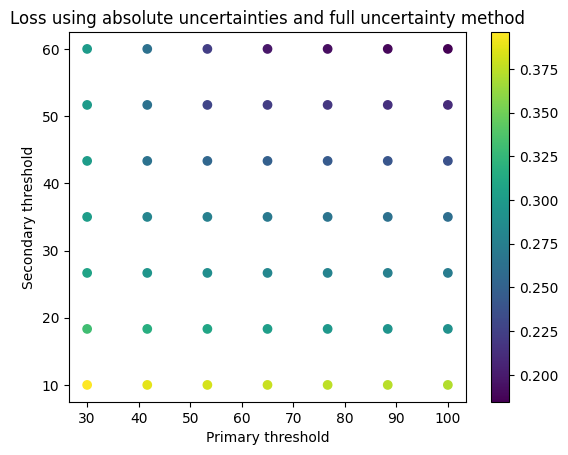

In [29]:
x = np.array(spectra)[:, 0]
y = np.array(spectra)[:, 1]
z = [np.nanmean(i.count_uncs) for i in np.array(spectra)[:, 2]]

plt.scatter(x, y, c=z, cmap="viridis")
plt.colorbar()
plt.xlabel("Primary threshold")
plt.ylabel("Secondary threshold")
plt.title("Loss using absolute uncertainties and full uncertainty method")

In [16]:
spcs

[[30.0, 10.0, <spc.SPC at 0x2f135f52390>],
 [30.0, 18.333333333333336, <spc.SPC at 0x2f129944650>],
 [30.0, 26.666666666666668, <spc.SPC at 0x2f119c5e910>],
 [30.0, 35.0, <spc.SPC at 0x2f10a97ab50>],
 [30.0, 43.333333333333336, <spc.SPC at 0x2f129a8cd50>],
 [30.0, 51.66666666666667, <spc.SPC at 0x2f1292c15d0>],
 [30.0, 60.0, <spc.SPC at 0x2f10a426790>],
 [41.666666666666664, 10.0, <spc.SPC at 0x2f1296a9a50>],
 [41.666666666666664, 18.333333333333336, <spc.SPC at 0x2f1294aac50>],
 [41.666666666666664, 26.666666666666668, <spc.SPC at 0x2f10a2a0ed0>],
 [41.666666666666664, 35.0, <spc.SPC at 0x2f135d9fd10>],
 [41.666666666666664, 43.333333333333336, <spc.SPC at 0x2f135d9ddd0>],
 [41.666666666666664, 51.66666666666667, <spc.SPC at 0x2f135d9d550>],
 [41.666666666666664, 60.0, <spc.SPC at 0x2f135d9fc90>],
 [53.33333333333333, 10.0, <spc.SPC at 0x2f135d9cfd0>],
 [53.33333333333333, 18.333333333333336, <spc.SPC at 0x2f135c22690>],
 [53.33333333333333, 26.666666666666668, <spc.SPC at 0x2f10a97d6

# Getting the image energies

In [2]:
import h5py
import itertools
import pandas as pd
import numpy as np
f_name = "data/sxro6416-r0504.h5"

datafile = h5py.File(f_name, "r")

data1, data2, data3 = [], [], []

for i in itertools.count(start=0):
    d1 = datafile.get(f"/Configure:0000/Run:0000/CalibCycle:{i:04d}/Bld::BldDataEBeamV7/EBeam/data")
    d2 = datafile.get(f"/Configure:0000/Run:0000/CalibCycle:{i:04d}/Bld::BldDataFEEGasDetEnergyV1/FEEGasDetEnergy/data")
    d3 = datafile.get(f"/Configure:0000/Run:0000/CalibCycle:{i:04d}/Bld::BldDataGMDV2/GMD/data")
    
    if d1 is not None:
        data1.append(d1[0])
        data2.append(d2[0])
        data3.append(d3[0])
    else:
        break

colnames1 = eval(str(np.array(data1).dtype))
colnames2 = eval(str(np.array(data2).dtype))
colnames3 = eval(str(np.array(data3).dtype))
pd.set_option("display.max_columns", None)

In [3]:

pd.DataFrame(np.array(data1))

,uDamageMask,fEbeamCharge,fEbeamL3Energy,fEbeamLTUPosX,fEbeamLTUPosY,fEbeamLTUAngX,fEbeamLTUAngY,fEbeamPkCurrBC2,fEbeamEnergyBC2,fEbeamPkCurrBC1,fEbeamEnergyBC1,fEbeamUndPosX,fEbeamUndPosY,fEbeamUndAngX,fEbeamUndAngY,fEbeamXTCAVAmpl,fEbeamXTCAVPhase,fEbeamDumpCharge,fEbeamPhotonEnergy,fEbeamLTU250,fEbeamLTU450
0,0,0.255432,5549.680668,0.054813,-0.009504,0.149521,0.019006,1158.342163,0.183105,218.907013,-0.082597,0.000154,-0.001169,0.000004,0.000273,85.000633,95.819420,1.182645e+09,1399.075506,-0.068495,0.033650
1,0,0.242501,5555.566573,0.035330,-0.009834,0.146987,0.018898,1202.583862,-0.170276,212.953079,-0.042622,0.000542,0.002419,-0.000162,-0.000219,84.981201,95.853813,1.135183e+09,1402.092107,0.059348,-0.102200
2,0,0.256141,5548.734367,0.023188,-0.013138,0.151041,0.017211,1170.566284,0.099223,213.886948,0.043819,-0.022250,-0.000809,0.000757,0.000110,85.030167,95.814896,1.180388e+09,1398.705656,-0.090178,0.054253
3,0,0.253013,5551.359178,0.047011,-0.011098,0.151146,0.018166,1177.506470,0.046767,213.616547,-0.053797,-0.011518,-0.003375,0.000502,0.000127,84.967743,95.813995,1.186804e+09,1400.144200,-0.031693,-0.004713
4,0,0.245640,5554.029829,0.020456,-0.006098,0.137155,0.020734,1196.580078,0.134568,215.192017,0.033124,-0.008030,0.003328,-0.000551,-0.000053,85.040047,95.912796,1.150184e+09,1401.156774,0.037806,-0.053744
5,0,0.251936,5552.505476,0.061291,-0.010441,0.155477,0.019988,1198.194702,0.098344,213.461807,-0.059136,0.003072,-0.002315,-0.000129,-0.000592,85.024582,95.705894,1.174556e+09,1400.610963,-0.004387,-0.028527
6,0,0.247685,5551.286251,0.038459,-0.010182,0.144493,0.019149,1177.090332,0.225949,209.253830,0.000066,-0.005074,-0.000575,0.000025,0.000166,84.979515,95.848839,1.157817e+09,1399.953255,-0.030682,-0.000182
7,0,0.247448,5554.219062,0.036869,-0.008072,0.142272,0.018975,1179.503052,-0.073105,213.692001,-0.053413,0.001425,-0.002672,-0.000255,-0.000219,85.035866,95.808792,1.155316e+09,1401.507792,0.026256,-0.075295
8,15360,0.252107,5550.554712,0.050664,-0.010739,0.151451,0.017395,1248.595459,0.165074,213.515915,0.003816,0.001425,-0.002672,-0.000255,-0.000219,84.928497,95.835739,1.168213e+09,1399.576999,-0.052865,0.009796
9,15360,0.253973,5552.885687,0.076717,-0.013737,0.166074,0.019059,1257.818481,0.010520,213.068619,-0.050127,0.001425,-0.002672,-0.000255,-0.000219,84.968124,95.745880,1.178142e+09,1400.726225,-0.006875,-0.049094


In [4]:
pd.DataFrame(np.array(data2))

,f_11_ENRC,f_12_ENRC,f_21_ENRC,f_22_ENRC,f_63_ENRC,f_64_ENRC
0,2.580547,2.602288,2.608079,2.417566,2.053639,0.348402
1,2.777072,2.780455,2.825415,2.639768,2.234563,0.348415
2,2.259775,2.278832,2.250527,2.051083,1.777520,0.348339
3,2.428009,2.436136,2.437397,2.232167,1.938169,0.348311
4,2.621613,2.626323,2.671714,2.461949,2.113321,0.348296
5,2.414194,2.438080,2.430803,2.212033,1.921731,0.348415
6,2.646310,2.675303,2.706082,2.513607,2.120461,0.348479
7,2.584618,2.590287,2.620438,2.433171,2.072336,0.348309
8,2.530751,2.556037,2.562509,2.376647,2.015724,0.348343
9,2.338558,2.349661,2.313345,2.117411,1.831653,0.348353


In [5]:
pd.DataFrame(np.array(data3))

,fMilliJoulesPerPulse,fMilliJoulesAverage,fSumAllPeaksFiltBkgd,fRawAvgBkgd,fRelativeEnergyPerPulse,fSumAllPeaksRawBkgd
0,2.952507,0.002743,445975.298920,24653.257143,1.903162e+11,446298.057143
1,3.145502,0.005297,475024.530867,24650.285714,2.027565e+11,475010.285714
2,2.442296,0.006101,368753.667903,24650.448980,1.574284e+11,368570.448980
3,2.638954,0.006181,398383.847337,24575.771429,1.701048e+11,387118.171429
4,2.971034,0.004659,448500.116353,24628.995918,1.915104e+11,445235.395918
5,2.711263,0.005566,409252.316463,24656.261224,1.747658e+11,410086.661224
6,3.021913,0.007048,456091.175762,24630.791837,1.947901e+11,453197.191837
7,2.890191,0.006539,436159.417442,24703.412245,1.862994e+11,443897.012245
8,2.784997,0.006097,420277.244036,24659.265306,1.795187e+11,421507.265306
9,2.527726,0.006713,381387.317460,24648.979592,1.629352e+11,381392.979592
